# **Medical Generative Adversarial Nets (MedGAN)**

## Overview

In this notebook, [MedGAN (medical generative adversarial networks)](http://proceedings.mlr.press/v68/choi17a/choi17a.pdf) is implemented. MedGAN was proposed to learn from electronic healthcare records (EHRs) and then generate synthetic EHRs. The main reason to do so is to circumvent private issues when sharing sensitive medical records to the public. The original version of MedGAN only does *unconditional* generation thus is unable to generate patient records with the specific desired property. Here a slight adaption of MedGAN is made to form a *conditional* MedGAN that is able to generate patient EHRs who are probably diagnosed with heart failure.


## About Raw Data
Heart failure prediction will be performed by using the diagnosis codes. The dataset is synthesized from MIMIC-III.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pdb
import sys
import pickle
import random
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
os.environ['PYTHONASHSEED'] = str(seed)

# define data set path
DATA_PATH = "/content/drive/My Drive/RETAIN-lib/data/"

In [5]:
pids = pickle.load(open(os.path.join(DATA_PATH,'train/pids.pkl'), 'rb'))
vids = pickle.load(open(os.path.join(DATA_PATH,'train/vids.pkl'), 'rb'))
hfs = pickle.load(open(os.path.join(DATA_PATH,'train/hfs.pkl'), 'rb'))
seqs = pickle.load(open(os.path.join(DATA_PATH,'train/seqs.pkl'), 'rb'))
types = pickle.load(open(os.path.join(DATA_PATH,'train/types.pkl'), 'rb'))
rtypes = pickle.load(open(os.path.join(DATA_PATH,'train/rtypes.pkl'), 'rb'))

assert len(pids) == len(vids) == len(hfs) == len(seqs) == 1000
assert len(types) == 619

where

- `pids`: contains the patient ids
- `vids`: contains a list of visit ids for each patient
- `hfs`: contains the heart failure label (0: normal, 1: heart failure) for each patient
- `seqs`: contains a list of visit (in ICD9 codes) for each patient
- `types`: contains the map from ICD9 codes to ICD-9 labels
- `rtypes`: contains the map from ICD9 labels to ICD9 codes


In [6]:
print("number of heart failure patients:", sum(hfs))
print("ratio of heart failure patients: %.2f" % (sum(hfs) / len(hfs)))

number of heart failure patients: 548
ratio of heart failure patients: 0.55


## 1 Build Dataloader

### 1.1 CustomDataset

First of all, let's implement a custom dataset using PyTorch class `Dataset`, which will characterize the key features of the dataset we want to generate.

We will use the sequences of diagnosis codes `seqs` as input and heart failure `hfs` as output.

In [7]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, seqs, hfs):
        self.x = seqs
        self.y = hfs
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]

dataset = CustomDataset(seqs, hfs)

### 1.2 Data Collator




In [8]:
class Collator:
    def __init__(self, total_number_of_codes):
        self.max_num_codes = total_number_of_codes

    def __call__(self, data):
        ''' flatten the input sequence samples into a multi-hot diagnosis codes,
            data: a list of samples fetched from 'CustomDataset'

        Outputs:
            x: a tensor of shape (# patients, max # diagnosis codes) with torch.float
            y: a tensor of shape (# patients, ) with type torch.float
        '''
        sequences, labels = zip(*data)
        num_patients = len(sequences)
        max_num_codes =  self.max_num_codes
        y = torch.tensor(labels, dtype=torch.float)
        x = torch.zeros((num_patients, max_num_codes), dtype=torch.float)

        for i_patient, patient in enumerate(sequences):
            unique_codes = set()
            for visit in patient:
                unique_codes.update(set(visit))
            for code in unique_codes:
                x[i_patient, code] = 1.0
        return x, y

collate_fn = Collator(len(types))

## 2 Naive AutoEncoder

A naive AutoEncoder is implemented as done in original MedGAN. The first stage is to learn an AutoEncoder by taking reconstruction of the input $x$ by predicting $\hat{x}$.

As done in `Dataset` and `DataLoader`, the input $x$ is a binary vector with size (batch_size, # diag codes).

We can make a simple encoder with one hidden linear layer `nn.Linear` by transforming $x$ to representations $h$ with size (batch size, hidden dimension). Then, we make a decoder also with one hidden linear layer `nn.Linear` by transforming $h$ to $\hat{x}$ with the same size as $x$.

We will take `nn.Sigmoid` as the prediction activation to map logits $\hat{x}$ to $[0,1]$.

The detailed model architecture is shown in the table below.

Layers | Configuration | Activation Function | Output Dimension (batch, feature)
--- | --- | --- | ---
fully connected | input size **input_dim**, output size **hidden_dim** | Tanh | (batch_size, hidden_dim)
fully connected | input size **hidden_dim**, output size **input_dim** | Sigmoid | (batch_size, input_dim)

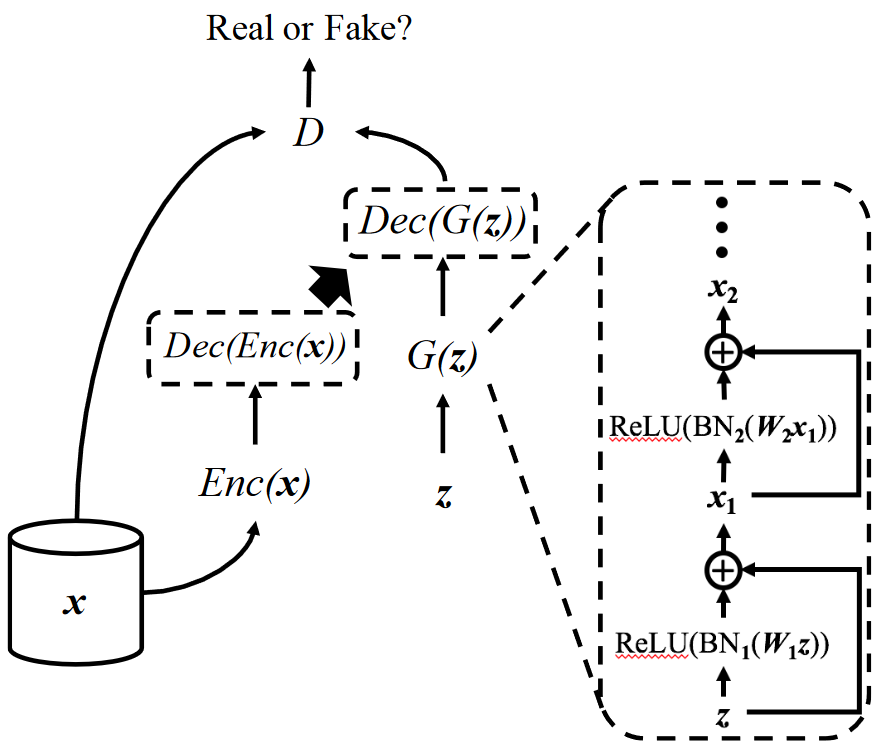

In [10]:
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/RETAIN-lib/img/medgan.png"))

### 2.1 Build the AutoEncoder model

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        '''
        initialize an auto-encoder
        self.encoder: linear - tanh activation
        self.decoder: linear - sigmoid activation
        '''
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        '''
        take the input patient records, encode them into hidden representations
        using the encoder.
        Arguments:
            x: the patient records with shape (batch_size, max # diagnosis codes)
        Outputs:
            h: the encoded representations with shape (batch_size, hidden_dim)
        '''
        h = self.encoder(x)
        return h

    def decode(self, h):
        '''
        take the input hidden representations, output the reconstructed patient records
        using the decoder.
        Arguments:
            h: the encoded representations with shape (batch_size, hidden_dim)
        Outputs:
            x: the patient records with shape (batch_size, max # diagnosis codes)
        '''
        x = self.decoder(h)
        return x

    def forward(self, x):
        '''
        call the self.encode and self.decode and finally output the reconstructed input x.
        Arguments:
            x: the patient records with shape (batch_size, max # diagnosis codes)
        Outputs:
            x: the reconstructed patient records with shape (batch_size, max # diagnosis codes)
        '''
        h = self.encode(x)
        x = self.decode(h)
        return x

model = AutoEncoder(1000, 256)

### 2.2 Train the AutoEncoder model

With the built AE model at hand, it is easy to follow the common practice to train AE using reconstruction loss.

Let's make use of the completed `CustomDataset`, `Collator`, and `AutoEncoder` to achieve this!

epoch 0 training autoencoer loss 5.23966783285141
epoch 1 training autoencoer loss 3.7646305561065674
epoch 2 training autoencoer loss 2.073987528681755
epoch 3 training autoencoer loss 1.2772767841815948
epoch 4 training autoencoer loss 1.0477388575673103
epoch 5 training autoencoer loss 0.9761749058961868
epoch 6 training autoencoer loss 0.9438871741294861
epoch 7 training autoencoer loss 0.9221657738089561
epoch 8 training autoencoer loss 0.9060243964195251
epoch 9 training autoencoer loss 0.8926374763250351
epoch 10 training autoencoer loss 0.880375012755394
epoch 11 training autoencoer loss 0.868371419608593
epoch 12 training autoencoer loss 0.8563124239444733
epoch 13 training autoencoer loss 0.8441486582159996
epoch 14 training autoencoer loss 0.831887811422348
epoch 15 training autoencoer loss 0.8195740878582001
epoch 16 training autoencoer loss 0.8072590529918671
epoch 17 training autoencoer loss 0.7949887216091156
epoch 18 training autoencoer loss 0.7828104794025421
epoch 19 

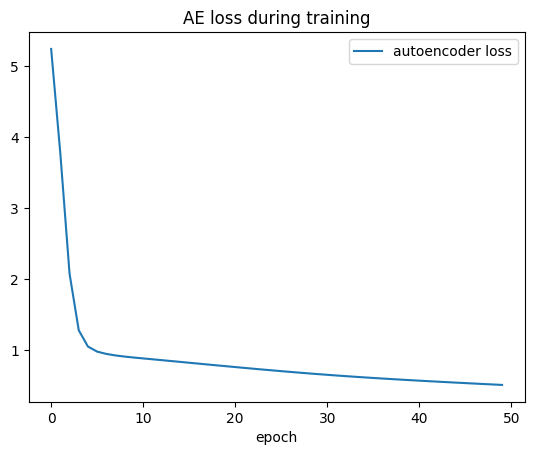

In [14]:
'''
Define the optimizer (Adam) with learning rate 1e-3.
Define the loss_fn (loss function, nn.BCELoss).
Do the training in each iteration by
- forward ae model to get x_hat
- compute reconstruction loss
- call loss.backward
- update parameters using optimizer.step
'''

from torch.utils.data import DataLoader
dataset = CustomDataset(seqs, hfs)
collate_fn = Collator(len(types))
dataloader = DataLoader(dataset, batch_size=128, collate_fn=collate_fn)
ae = AutoEncoder(input_dim=len(types), hidden_dim=256)

optimizer, loss_fn = torch.optim.Adam(ae.parameters(), lr=1e-3), nn.BCELoss()

loss_list = []
for epoch in range(50):
    epoch_loss = 0
    for (x,y) in dataloader:
        optimizer.zero_grad()
        x_hat = ae(x) # Forward pass to get the reconstructed data
        loss = loss_fn(x_hat, x) # Compute the reconstruction loss
        loss.backward()  # Compute gradient of the loss with respect to parameters
        optimizer.step()  # Update parameters with gradients
        epoch_loss += loss.item()
    loss_list.append(epoch_loss)
    print(f'epoch {epoch} training autoencoer loss {epoch_loss}')

import matplotlib.pyplot as plt
plt.plot(loss_list, label='autoencoder loss')
plt.xlabel('epoch')
plt.title('AE loss during training')
plt.legend()
plt.show()

## 3 MedGAN

### 3.1 Build the Generator and Discrminator [30 points]

Next, we will construct the generator and discriminator of the MedGAN model.

Note that we take a conditional GAN here, the input of generator should be the concatenation of $z$ vector and the condition $y$. Meanwhile, the input of discriminator is the concatenation of $x$ vector and the condition $y$.

<img src="img/conditional-gan.png" width="400"/>

This figure is drawn from the paper [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf). In our case, the condition $y$ is a value in $\{0,1\}$ indicating whether the patient has heart failure or not.


The architecture details are as follows.

**Generator**

Layers | Configuration | Activation Function | Output Dimension (batch, feature)
--- | --- | --- | ---
batchnorm1d | - | - | (batch_size, input_dim)
ReLU | - | - |  (batch_size, input_dim)
fully connected | input size **input_dim**, output size **hidden_dim** | - | (batch_size, hidden_dim)
batchnorm1d | - | - | (batch_size, hidden_dim)
Tanh | - | - |  (batch_size, hidden_dim)
fully connected | input size **hidden_dim**, output size **hidden_dim** | - | (batch_size, hidden_dim)


**Discrminator**

Layers | Configuration | Activation Function | Output Dimension (batch, feature)
--- | --- | --- | ---
fully connected | input size **input_dim**, output size **hidden_dim** | - | (batch_size, hidden_dim)
ReLU | - | - |  (batch_size, input_dim)
fully connected | input size **hidden_dim**, output size **1** | - | (batch_size, 1)
Sigmoid | - | - |  (batch_size, 1)

In [16]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        '''input records and labels for conditional generation
        '''
        super().__init__()
        # DO NOT change the names
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.act2 = nn.Tanh()

    def forward(self, z, y):
        '''
        Arguments:
            z: input random noise with shape (n, hidden_dim)
            y: input conditional y with shape (n,)
        Outputs:
            h: the generated representation h with shape (n, hidden_dim)

        take the defined components to do forward inference.
        take the *residual connection* for each layer as described in MedGAN paper,
        i.e., (z,y) -> tmp -> layer1(bn1+act1+linear1) -> h -> h = h + z -> bn2 -> z ->
        layer2(act2+linear2) -> h -> h = h+z

        '''
        tmp = torch.cat([z, y[:,None]], 1)
        h = self.linear1(self.act1(self.bn1(tmp)))
        h += z
        z = self.bn2(h)
        h = self.linear2(self.act2(z))
        h += z
        return h
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        '''input records and labels for conditional discrimination
        '''
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.act2 = nn.Sigmoid()
    def forward(self, x, y):
        '''
        Arguments:
            x: input records with shape (n, input_dim)
            y: input conditional labels with shape (n,)
        Outputs:
            out: the predicted probability if input x is real or fake samples in shape (n,)
        '''
        x = torch.cat([x, y[:,None]], axis=1)
        out = self.act1(self.linear1(x))
        out = self.act2(self.linear2(out))
        return out.squeeze(1)

generator = Generator(100, 99)
discriminator = Discriminator(100, 10)

### 3.2 Build the MedGAN model

Now, finally we come to build our conditional MedGAN with all completed components: AutoEncoder, Generator, Discriminator.

In the MedGAN training phase, only the `decoder` of the AutoEncoder model will be used to decode the outputs of the `generator`.

Also, we need a `generate` function for `MedGAN` such that it is able to generate fake samples for `discriminator` to classify.

In the `forward` function, we need to implement the compution for discriminator and generator loss.

$\ell_{d}= - \frac1m \sum_{i=1}^m [log (D(x_i)+\epsilon) + \log (1-D(\hat{x}_i)+\epsilon)]$

$\ell_{g}= - \frac1m \sum_{i=1}^m log (D(\hat{x}_i)+\epsilon)$

where $x_i$ is the real record and $\hat{x}_i$ is the fake record generated by generator;

$\epsilon$ is added to avoid numerical issue in the $log$ function.


In [19]:
class MedGAN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        '''The main class for MedGAN model. It consists of three parts:
        AutoEncoder
        Generator
        Discriminator
        '''
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.ae = AutoEncoder(input_dim, hidden_dim)
        self.generator = Generator(hidden_dim + 1, hidden_dim) # input random noise/representation + label
        self.discriminator = Discriminator(input_dim + 1, hidden_dim) # input records + label

    def generate(self, n, y):
        '''
        Arguments:
            n: number of fake samples to be generated
            y: the condition label used to make conditional generation
        Outputs:
            x: the generated fake samples with shape (n, self.input_dim)

        Generate n fake samples using the generator.
        First, sample a random vector z using torch.randn with size (n, self.hidden_dim).
        Then, generate the fake encoded representations h using z and y as inputs for self.generator .
        Last, generate the fake example x using self.ae.decode function.
        '''
        z = torch.randn(n, self.hidden_dim)
        h = self.generator(z, y)
        x = self.ae.decode(h)

        return x

    def forward(self, x, y):
        '''Take the input x and conditional y, compute the discriminator loss and generator loss
        Arguments:
            x: input records with shape (n, self.input_dim)
            y: input labels with shape (n,)
        Outputs:
            d_loss: discriminator loss values
            g_loss: generator loss values

        Implement the prediction of fake or real examples using self.discriminator.
        Then, compute the discriminator loss and generator loss.
        '''
        x_fake = self.generate(len(x), y)

        real_score = self.discriminator(x, y)
        fake_score = self.discriminator(x_fake, y)

        epsilon = 1e-8
        d_loss = -torch.mean(torch.log(real_score + epsilon) + torch.log(1 - fake_score + epsilon))
        g_loss = -torch.mean(torch.log(fake_score + epsilon))

        return g_loss, d_loss

medgan = MedGAN(100, 128)

### 3.3 Build optimizers for MedGAN
Now we turn to build optimizers for MedGAN. Note that GAN model trains generator and discriminator in an adversarial paradigm, we need to split their parameters when designing optimizers.


In [21]:
def build_optimizer(medgan):
    '''build two separate optimizers for the generator and discriminator, respectively.

    add params which belong to AutoEncoder and Generator to g_param_list;
    add params which belong to discriminator to d_param_list.
    '''
    g_param_list, d_param_list = [], []
    for name, param in medgan.named_parameters():
        if 'discriminator' in name:
            d_param_list.append(param)
        else:
            g_param_list.append(param)
    g_optimizer = torch.optim.Adam(g_param_list, lr=1e-4)
    d_optimizer = torch.optim.Adam(d_param_list, lr=1e-4)
    return g_optimizer, d_optimizer

### 3.4 Train MedGAN and generate synthetic records

Finally, train the MedGAN model and use it to generate synthetic records we want.

In [22]:
# build dataloader
from torch.utils.data import DataLoader
dataset = CustomDataset(seqs, hfs)
collate_fn = Collator(len(types))
dataloader = DataLoader(dataset, batch_size=128, collate_fn=collate_fn)

# build model
medgan = MedGAN(input_dim=len(types), hidden_dim=256)

# apply the pretrained ae model to medgan autoencoder model
medgan.ae.load_state_dict(ae.state_dict())

# build optimizer for generator and discriminator, respectively
g_opt, d_opt = build_optimizer(medgan)

n_epochs = 40
d_train_period = 1
g_train_period = 2

g_loss_list, d_loss_list = [], []
for epoch in range(n_epochs):
    medgan.train()
    g_loss_all, d_loss_all = 0, 0
    for (x,y) in dataloader:
        for _ in range(d_train_period):
            d_opt.zero_grad()  # Zero the gradients of the discriminator
            g_loss, d_loss = medgan(x, y)  # Forward pass through MedGAN
            d_loss.backward()  # Backpropagate the discriminator loss
            d_opt.step()  # Update the discriminator parameters
            d_loss_all += d_loss.item()

        for _ in range(g_train_period):
            g_opt.zero_grad()
            g_loss, _ = medgan(x, y)
            g_loss.backward()
            g_opt.step()
            g_loss_all += g_loss.item()

    g_loss_list.append(g_loss_all)
    d_loss_list.append(d_loss_all)
    print(f'Epoch {epoch} Generator loss {g_loss_all} Discriminator loss {d_loss_all}')

Epoch 0 Generator loss 14.942980885505676 Discriminator loss 10.095545411109924
Epoch 1 Generator loss 25.29406499862671 Discriminator loss 7.818586945533752
Epoch 2 Generator loss 35.529311299324036 Discriminator loss 6.746001720428467
Epoch 3 Generator loss 43.55790185928345 Discriminator loss 6.207983613014221
Epoch 4 Generator loss 48.889084577560425 Discriminator loss 5.844813346862793
Epoch 5 Generator loss 51.772942543029785 Discriminator loss 5.578364670276642
Epoch 6 Generator loss 53.251140117645264 Discriminator loss 5.346174955368042
Epoch 7 Generator loss 53.72038745880127 Discriminator loss 5.174263060092926
Epoch 8 Generator loss 53.19954705238342 Discriminator loss 5.039412975311279
Epoch 9 Generator loss 52.466334104537964 Discriminator loss 4.965331196784973
Epoch 10 Generator loss 51.827290296554565 Discriminator loss 4.963357627391815
Epoch 11 Generator loss 51.01087927818298 Discriminator loss 5.119285941123962
Epoch 12 Generator loss 49.35841155052185 Discriminato

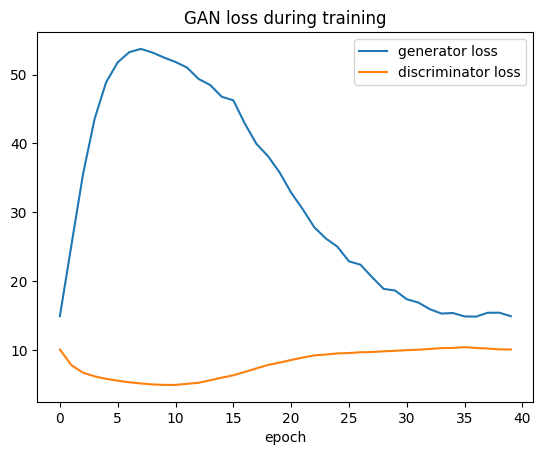

In [23]:
import matplotlib.pyplot as plt
plt.plot(g_loss_list, label='generator loss')
plt.plot(d_loss_list, label='discriminator loss')
plt.xlabel('epoch')
plt.title('GAN loss during training')
plt.legend()
plt.show()

To verify if our MedGAN is able to do conditional generation, we design an experiment like:

- Train a heart failure classifier on the real EHRs record from which MedGAN learns.
- Use the trained MedGAN to generate synthetic records with given condition in $\{0,1\}$
- Use the trained classifier to make predictions on synthetic records to see if the predicted outcomes match the given condition.

If the predicted outcome matches the given condition well, our MedGAN does a great job because it succeeds to produce records which are fit to the given condition. Let's start!

In [24]:
# train a classifier on the real records so we can classify if one patient record belongs to heart failure case
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.clf = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        pred = self.clf(x).squeeze(1)
        return pred

from torch.utils.data import DataLoader
dataset = CustomDataset(seqs, hfs)
collate_fn = Collator(len(types))
dataloader = DataLoader(dataset, batch_size=64, collate_fn=collate_fn)
clf = Classifier(len(types), 256)
optimizer = torch.optim.Adam(clf.parameters(), 1e-3)
loss_fn = nn.BCELoss()
for epoch in range(10):
    epoch_loss = 0
    for (x,y) in dataloader:
        optimizer.zero_grad()
        pred = clf(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'epoch {epoch} training classifier loss {epoch_loss}')

epoch 0 training classifier loss 9.389822453260422
epoch 1 training classifier loss 6.31385800242424
epoch 2 training classifier loss 4.873824328184128
epoch 3 training classifier loss 3.694623664021492
epoch 4 training classifier loss 2.6869661137461662
epoch 5 training classifier loss 1.9123459309339523
epoch 6 training classifier loss 1.3512766174972057
epoch 7 training classifier loss 0.9650243707001209
epoch 8 training classifier loss 0.7074727639555931
epoch 9 training classifier loss 0.5319214127957821


Now let's generate synthetic records and test!

In [25]:
print('generate 100 synthetic records with/without heart failure')
y = torch.cat([torch.ones(50), torch.zeros(50)], 0)
medgan.eval()
with torch.no_grad():
    x = medgan.generate(100, y)
    pred = clf(x)


print('evaluate how much the generated synthetic records match the given condition:')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y.long().numpy(), pred.numpy())
print('auc:', auc)

pred[pred>0.5]=1
pred[pred<=0.5]=0
acc = (pred == y).float().mean().item()
print('accuracy:', acc)

generate 100 synthetic records with/without heart failure
evaluate how much the generated synthetic records match the given condition:
auc: 0.5611999999999999
accuracy: 0.5600000023841858


Since training a GAN model has long been "random", it is possible that the model doesn't perform so well.
The reason might be

(1) the training records are so small. Here only have 1000 records.

(2) the conditional GAN does not capture the given condition well.